# Mount drive

In [1]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Install dependencies

In [2]:
!pip install discopy==1.1.4
!pip install lambeq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.9/144.9 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.1/152.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.3/364.3 kB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 11.2 MB/s eta 0:00:00


# Import libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# QNLP
from lambeq.tokeniser import SpacyTokeniser
from lambeq import BobcatParser, spiders_reader, cups_reader, TreeReader, TreeReaderMode, stairs_reader
from lambeq import Rewriter, SimpleRewriteRule, remove_cups, AtomicType, TensorAnsatz, SpiderAnsatz
from discopy.tensor import Dim
from discopy.grammar.pregroup import Cap, Id, Diagram
S = AtomicType.SENTENCE
N = AtomicType.NOUN
P = AtomicType.PREPOSITIONAL_PHRASE
C = AtomicType.CONJUNCTION

# Training
from lambeq import PytorchModel, PytorchTrainer, Dataset, CrossEntropyLoss
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

# SEED for reproducibility
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Load data

In [4]:
QUANTUM_PATH = '/content/drive/MyDrive/Tesi/Master-Thesis/data/processed/quantum.csv'
CLASSICAL_PATH = '/content/drive/MyDrive/Tesi/Master-Thesis/data/processed/classical.csv'

df = pd.read_csv(CLASSICAL_PATH, index_col=False)

# Create string-diagrams
Uncomment rows for different readers

In [5]:
def create_multi_diagrams(df, reader):
    diagrams, targets = [], []
    for _, row in enumerate(df.to_numpy()):
        sentence, target = row[0], row[1]
        try:
            diagrams.append(reader.sentence2diagram(sentence))
        except Exception as e:
            print(sentence)
            print(e)
            continue
        if target == "US":
            targets.append([1.0, 0.0, 0.0, 0.0])
        elif target == "SE":
            targets.append([0.0, 1.0, 0.0, 0.0])
        elif target == "O":
            targets.append([0.0, 0.0, 1.0, 0.0])
        elif target == "PE":
            targets.append([0.0, 0.0, 0.0, 1.0])
    return diagrams, targets

reader = spiders_reader
# reader = cups_reader
# reader = stairs_reader
# reader = TreeReader(ccg_parser=BobcatParser, mode = TreeReaderMode.RULE_TYPE)

# reader = BobcatParser(root_cats=['S'])

diagrams, targets = create_multi_diagrams(df, reader)

# Rewrite string-diagrams
This step is not performed for linear readers (spiders, cups, etc.).

In [6]:
# def normalize_diagrams(diagrams):
#     normalized_diagrams = []
#     for i, diagram in enumerate(diagrams):
#         try:
#             normalized_diagrams.append(rewriter(diagram).normal_form())
#         except Exception as e:
#             print(e)
#             diagram.draw()
#             continue
#     return normalized_diagrams

# import nltk
# nltk.download('punkt')

# from nltk.probability import FreqDist
# from nltk.tokenize import word_tokenize
# from lambeq import UnknownWordsRewriteRule

# all_words = [word for tokens in df['RequirementText'].apply(lambda x: word_tokenize(x)) for word in tokens]
# freq_dist = FreqDist(all_words)
# common_words = [word for word, freq in freq_dist.items() if freq >= 2]

# unknown_rule = UnknownWordsRewriteRule(common_words)

# rewriter = Rewriter(['prepositional_phrase', 'determiner', 'connector', 'auxiliary', 'preadverb', 'coordination'])
# diagrams = normalize_diagrams(diagrams)

# Parameterize diagrams
Uncomment rows for different anstaze

In [7]:
def create_networks(diagrams, ansatz):
    networks = []
    for i, diagram in enumerate(diagrams):
        try:
            networks.append(ansatz(diagram))
        except Exception as e:
            print(e)
            diagram.draw(figsize=(8,5), fontsize=8)
            continue
    return networks

ob_map = {
    S: 2,
    # N: 2,
    # P: 2,
}

ansatz = TensorAnsatz(ob_map)
# ansatz = SpiderAnsatz(ob_map)

networks = create_networks(diagrams, ansatz)

# # check for codomain errors
# for i,c in enumerate(networks):
#     if str(c.cod) != 'Dim(4)':
#         networks[i].draw()

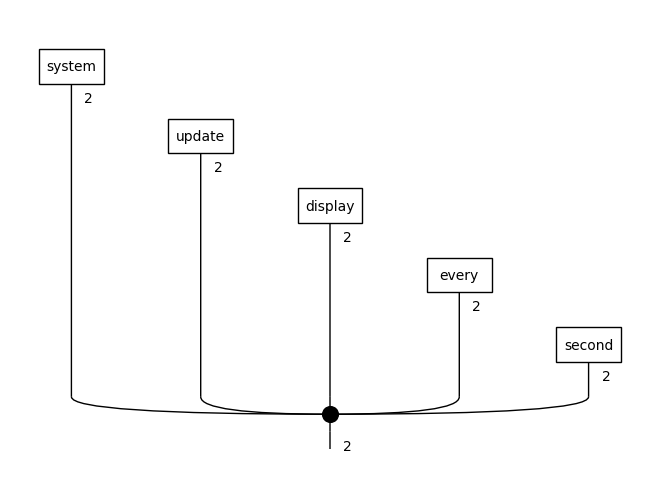

In [8]:
networks[0].draw()

# Define evalutation metrics

In [9]:
def accuracy(y_hat, y):
    y_true = torch.argmax(y, dim=1)
    y_pred = torch.argmax(y_hat, dim=1)
    return accuracy_score(y_true, y_pred)

def precision(y_hat, y):
    y_true = torch.argmax(y, dim=1)
    y_pred = torch.argmax(y_hat, dim=1)
    return precision_score(y_true, y_pred, average='weighted', zero_division=1)

def recall(y_hat, y):
    y_true = torch.argmax(y, dim=1)
    y_pred = torch.argmax(y_hat, dim=1)
    return recall_score(y_true, y_pred, average='weighted', zero_division=1)

def f1score(y_hat, y):
    y_true = torch.argmax(y, dim=1)
    y_pred = torch.argmax(y_hat, dim=1)
    return f1_score(y_true, y_pred, average='weighted', zero_division=1)

eval_metrics = {"prec": precision, "rec": recall, "acc": accuracy, "f1": f1score}

# Define model

In [10]:
class ClassicalModel(PytorchModel):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 4)

    def forward(self, input):
        x = self.get_diagram_output(input)
        x = torch.relu(self.fc1(x.float()))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Training

In [11]:
EPOCHS = 100
SPLIT = 10
EARLY_STOPPING = None

custom_primary = '#007FFF'
custom_secondary = '#FF6666'

## Grid Search

Epoch 1:    train/loss: 0.5973   valid/loss: 0.6007   train/prec: 0.7259   train/rec: 0.3365   train/acc: 0.3365   train/f1: 0.1940   valid/prec: 0.6949   valid/rec: 0.2500   valid/acc: 0.2500   valid/f1: 0.1448
Epoch 2:    train/loss: 0.5636   valid/loss: 0.5597   train/prec: 0.6260   train/rec: 0.2704   train/acc: 0.2704   train/f1: 0.1582   valid/prec: 0.5508   valid/rec: 0.3611   valid/acc: 0.3611   valid/f1: 0.1956
Epoch 3:    train/loss: 0.5620   valid/loss: 0.5530   train/prec: 0.7300   train/rec: 0.3553   train/acc: 0.3553   train/f1: 0.1890   valid/prec: 0.5508   valid/rec: 0.3611   valid/acc: 0.3611   valid/f1: 0.1956
Epoch 4:    train/loss: 0.5614   valid/loss: 0.5515   train/prec: 0.6169   train/rec: 0.3585   train/acc: 0.3585   train/f1: 0.2191   valid/prec: 0.5480   valid/rec: 0.3611   valid/acc: 0.3611   valid/f1: 0.2378
Epoch 5:    train/loss: 0.5627   valid/loss: 0.5500   train/prec: 0.6536   train/rec: 0.4057   train/acc: 0.4057   train/f1: 0.2986   valid/prec: 0.6220

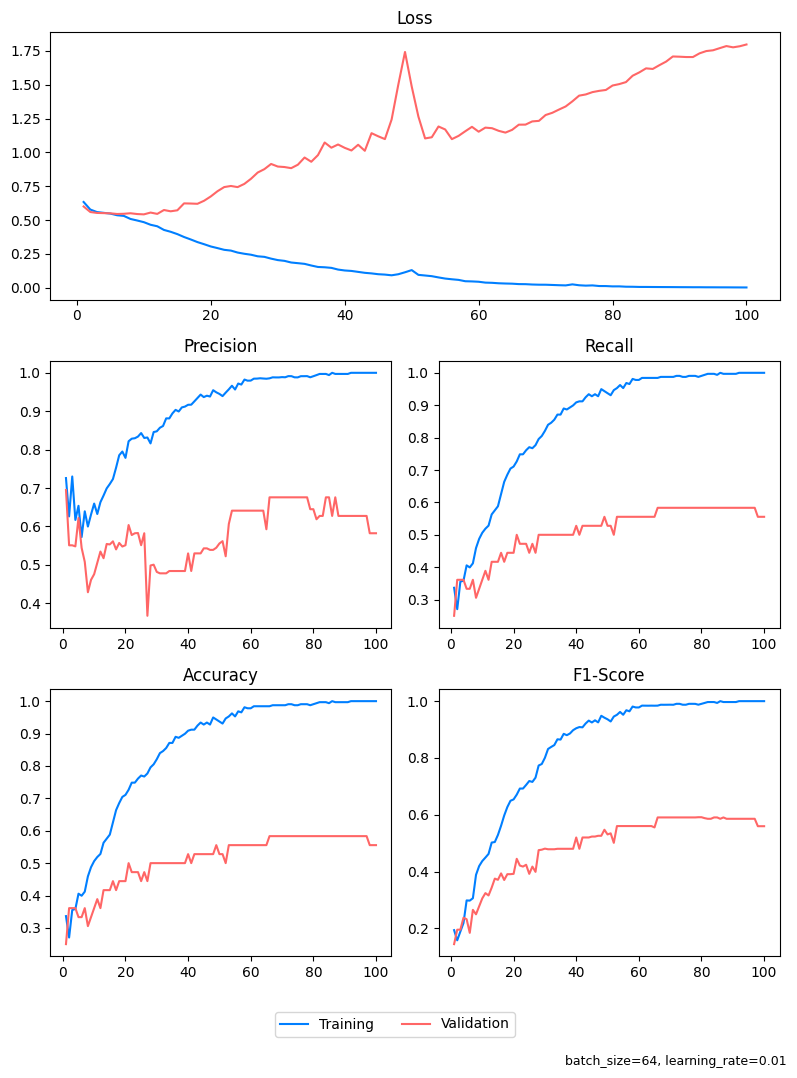

In [12]:
for bs in [64]:
    for lr in [1e-2]:
        X_train_grid, X_val_grid, y_train_grid, y_val_grid = train_test_split(networks, targets, test_size=1/SPLIT, random_state=SEED, stratify=targets)
        train_dataset = Dataset(X_train_grid, y_train_grid, batch_size=bs)
        val_dataset =  Dataset(X_val_grid, y_val_grid, shuffle=False)

        model = ClassicalModel.from_diagrams(networks)
        model.initialise_weights()

        trainer = PytorchTrainer(
                        model=model,
                        loss_function=torch.nn.BCEWithLogitsLoss(),
                        optimizer=torch.optim.AdamW,
                        learning_rate=lr,
                        epochs=EPOCHS,
                        evaluate_functions=eval_metrics,
                        evaluate_on_train=True,
                        verbose='text',
                        seed=SEED
                    )

        trainer.fit(train_dataset, val_dataset, log_interval=1)

        range_ = np.arange(1, len(trainer.train_epoch_costs) + 1)

        fig, axes = plt.subplot_mosaic('AA;BC;DE', figsize=(8, 10))

        axes['A'].plot(range_, trainer.train_epoch_costs, color=custom_primary, label='Training Loss')
        axes['A'].plot(range_, trainer.val_costs, color=custom_secondary, label='Validation Loss')
        axes['A'].set_title('Loss')

        axes['B'].plot(range_, trainer.train_eval_results['prec'], color=custom_primary, label='Training Precision')
        axes['B'].plot(range_, trainer.val_eval_results['prec'], color=custom_secondary, label='Validation Precision')
        axes['B'].set_title('Precision')

        axes['C'].plot(range_, trainer.train_eval_results['rec'], color=custom_primary, label='Training Recall')
        axes['C'].plot(range_, trainer.val_eval_results['rec'], color=custom_secondary, label='Validation Recall')
        axes['C'].set_title('Recall')

        axes['D'].plot(range_, trainer.train_eval_results['acc'], color=custom_primary, label='Training Accuracy')
        axes['D'].plot(range_, trainer.val_eval_results['acc'], color=custom_secondary, label='Validation Accuracy')
        axes['D'].set_title('Accuracy')

        axes['E'].plot(range_, trainer.train_eval_results['f1'], color=custom_primary, label='Training F1-Score')
        axes['E'].plot(range_, trainer.val_eval_results['f1'], color=custom_secondary, label='Validation F1-Score')
        axes['E'].set_title('F1-Score')

        for _, ax in axes.items():
            ax.legend().set_visible(False)

        fig.legend(['Training', 'Validation'], loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=2)
        plt.figtext(0.99, -0.07, f'batch_size={bs}, learning_rate={lr}', horizontalalignment='right', fontsize=9, color='black')

        plt.tight_layout()
        plt.savefig(f"/content/drive/MyDrive/Tesi/Master-Thesis/figures/grid-search/classical/multi/{bs}-{lr}.pdf", format="pdf", bbox_inches="tight")
        plt.show()

## K-fold cross validation
After grid-search we choose:

In [38]:
LEARNING_RATE = 1e-2
BATCH_SIZE = 64

Processing Fold 1 ...
Processing Fold 2 ...
Processing Fold 3 ...
Processing Fold 4 ...
Processing Fold 5 ...
Processing Fold 6 ...
Processing Fold 7 ...
Processing Fold 8 ...
Processing Fold 9 ...
Processing Fold 10 ...


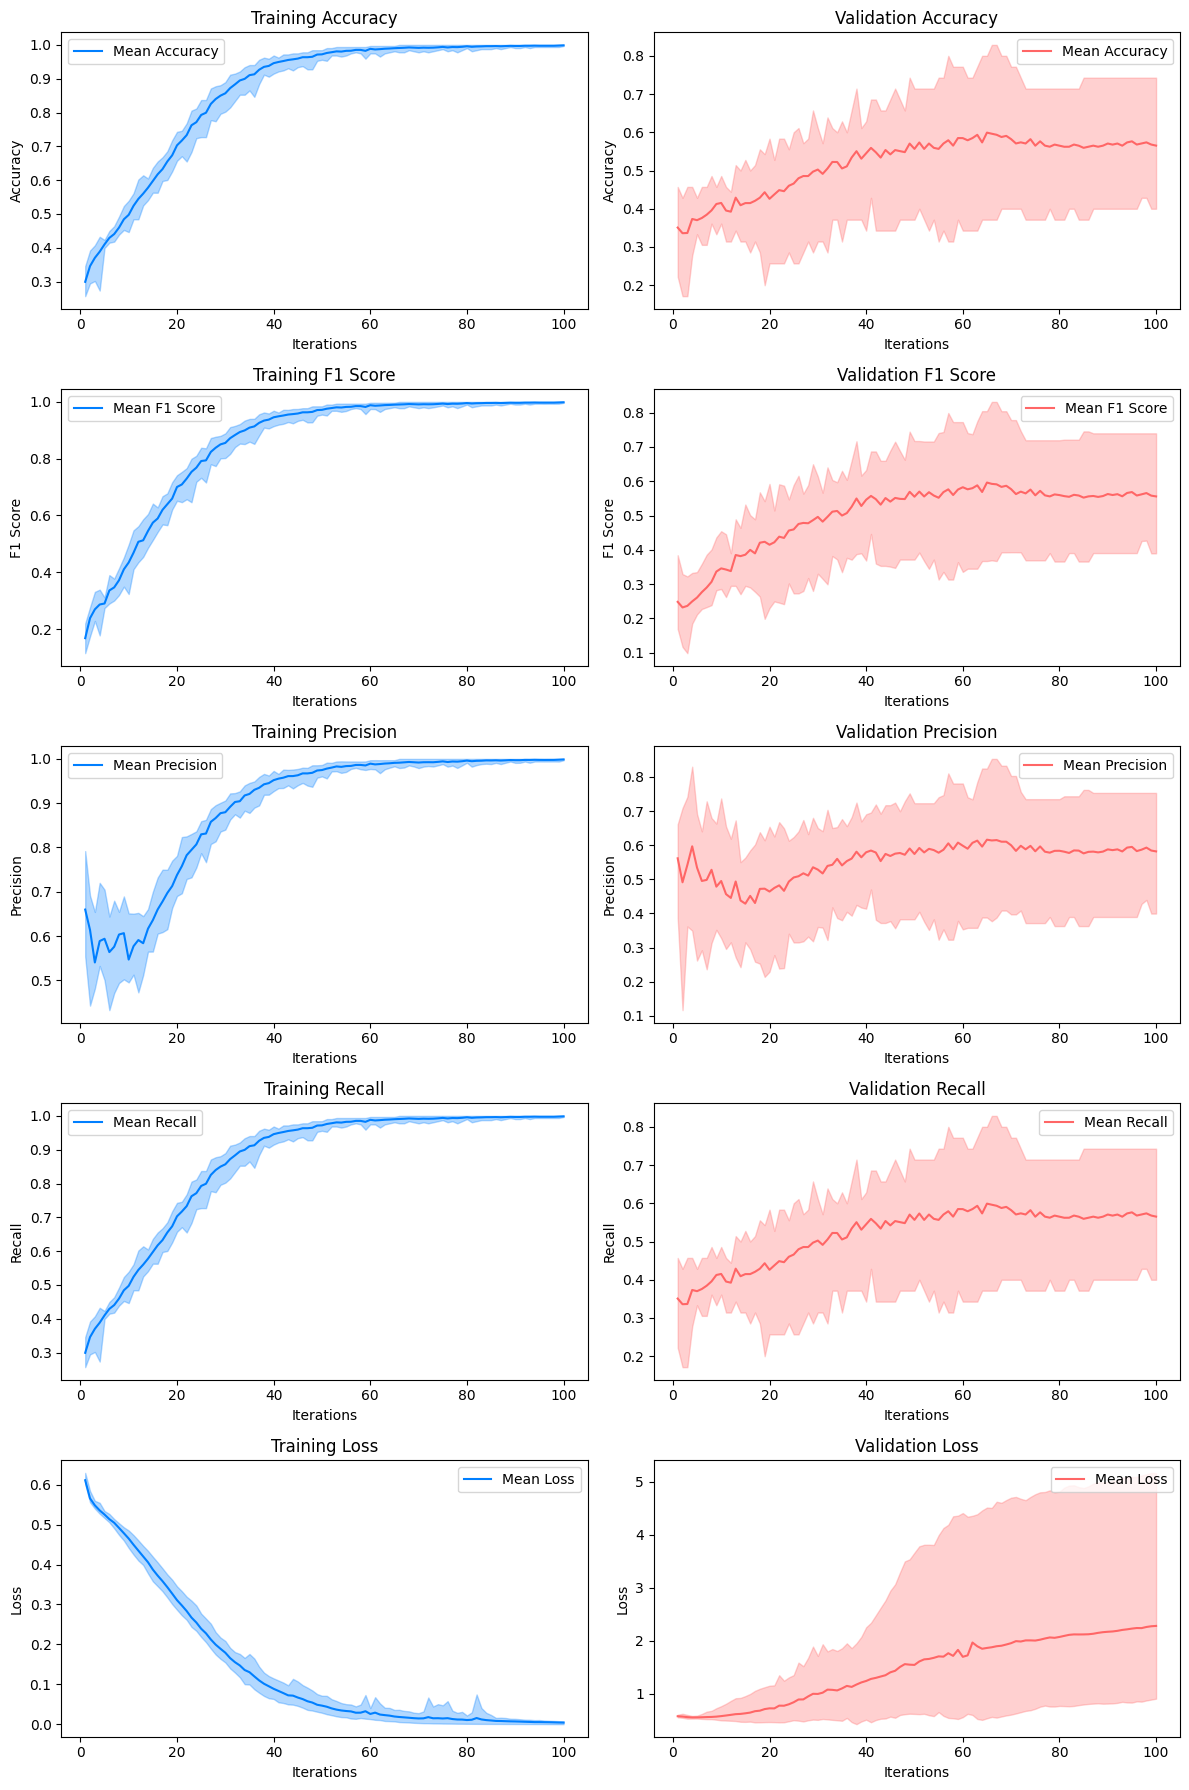

In [39]:
cv = StratifiedKFold(n_splits=SPLIT, random_state=SEED, shuffle=True)
networks_np = np.array(networks, dtype=object)
targets_np = np.array(targets, dtype=object)

train_losses = []
val_losses = []
train_precisions = []
val_precisions = []
train_recalls = []
val_recalls = []
train_accuracies = []
val_accuracies = []
train_f1 = []
val_f1 = []

for i, (train_index, val_index) in enumerate(cv.split(networks_np, targets_np.argmax(1))):

    print(f'Processing Fold {i+1} ...')

    train_fold = Dataset(networks_np[train_index], targets_np[train_index], batch_size=BATCH_SIZE)
    val_fold = Dataset(networks_np[val_index], targets_np[val_index])

    model = ClassicalModel.from_diagrams(networks)
    model.initialise_weights()

    trainer = PytorchTrainer(
        model=model,
        loss_function=torch.nn.BCEWithLogitsLoss(),
        optimizer=torch.optim.AdamW,
        learning_rate=LEARNING_RATE,
        epochs=EPOCHS,
        evaluate_functions=eval_metrics,
        evaluate_on_train=True,
        verbose='suppress',
        seed=SEED
    )

    trainer.fit(train_fold, val_fold, log_interval=1, early_stopping_interval=EARLY_STOPPING)

    train_losses.append(trainer.train_epoch_costs)
    val_losses.append(trainer.val_costs)

    train_precisions.append(trainer.train_eval_results['prec'])
    val_precisions.append(trainer.val_eval_results['prec'])

    train_recalls.append(trainer.train_eval_results['rec'])
    val_recalls.append(trainer.val_eval_results['rec'])

    train_accuracies.append(trainer.train_eval_results['acc'])
    val_accuracies.append(trainer.val_eval_results['acc'])

    train_f1.append(trainer.train_eval_results['f1'])
    val_f1.append(trainer.val_eval_results['f1'])


range_ = np.arange(1, len(trainer.train_epoch_costs) + 1)

mean_train_loss = np.mean(train_losses, axis=0)
min_train_loss = np.min(train_losses, axis=0)
max_train_loss = np.max(train_losses, axis=0)

mean_val_loss = np.mean(val_losses, axis=0)
min_val_loss = np.min(val_losses, axis=0)
max_val_loss = np.max(val_losses, axis=0)


mean_train_precision = np.mean(train_precisions, axis=0)
min_train_precision = np.min(train_precisions, axis=0)
max_train_precision = np.max(train_precisions, axis=0)

mean_val_precision = np.mean(val_precisions, axis=0)
min_val_precision = np.min(val_precisions, axis=0)
max_val_precision = np.max(val_precisions, axis=0)


mean_train_recall = np.mean(train_recalls, axis=0)
min_train_recall = np.min(train_recalls, axis=0)
max_train_recall = np.max(train_recalls, axis=0)

mean_val_recalls = np.mean(val_recalls, axis=0)
min_val_recalls = np.min(val_recalls, axis=0)
max_val_recalls = np.max(val_recalls, axis=0)


mean_train_accuracy = np.mean(train_accuracies, axis=0)
min_train_accuracy = np.min(train_accuracies, axis=0)
max_train_accuracy = np.max(train_accuracies, axis=0)

mean_val_accuracy = np.mean(val_accuracies, axis=0)
min_val_accuracy = np.min(val_accuracies, axis=0)
max_val_accuracy = np.max(val_accuracies, axis=0)


mean_train_f1 = np.mean(train_f1, axis=0)
min_train_f1 = np.min(train_f1, axis=0)
max_train_f1 = np.max(train_f1, axis=0)

mean_val_f1 = np.mean(val_f1, axis=0)
min_val_f1 = np.min(val_f1, axis=0)
max_val_f1 = np.max(val_f1, axis=0)


fig, axes = plt.subplots(5, 2, figsize=(12, 18))

axes[0, 0].set_title('Training Accuracy')
axes[0, 0].set_xlabel('Iterations')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].plot(range_, mean_train_accuracy, color=custom_primary, label='Mean Accuracy')
axes[0, 0].fill_between(range_, min_train_accuracy, max_train_accuracy, color=custom_primary, alpha=0.3)
axes[0, 0].legend()

axes[0, 1].set_title('Validation Accuracy')
axes[0, 1].set_xlabel('Iterations')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].plot(range_, mean_val_accuracy, color=custom_secondary, label='Mean Accuracy')
axes[0, 1].fill_between(range_, min_val_accuracy, max_val_accuracy, color=custom_secondary, alpha=0.3)
axes[0, 1].legend()

axes[1, 0].set_title('Training F1 Score')
axes[1, 0].set_xlabel('Iterations')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].plot(range_, mean_train_f1, color=custom_primary, label='Mean F1 Score')
axes[1, 0].fill_between(range_, min_train_f1, max_train_f1, color=custom_primary, alpha=0.3)
axes[1, 0].legend()

axes[1, 1].set_title('Validation F1 Score')
axes[1, 1].set_xlabel('Iterations')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].plot(range_, mean_val_f1, color=custom_secondary, label='Mean F1 Score')
axes[1, 1].fill_between(range_, min_val_f1, max_val_f1, color=custom_secondary, alpha=0.3)
axes[1, 1].legend()

axes[2, 0].set_title('Training Precision')
axes[2, 0].set_xlabel('Iterations')
axes[2, 0].set_ylabel('Precision')
axes[2, 0].plot(range_, mean_train_precision, color=custom_primary, label='Mean Precision')
axes[2, 0].fill_between(range_, min_train_precision, max_train_precision, color=custom_primary, alpha=0.3)
axes[2, 0].legend()

axes[2, 1].set_title('Validation Precision')
axes[2, 1].set_xlabel('Iterations')
axes[2, 1].set_ylabel('Precision')
axes[2, 1].plot(range_, mean_val_precision, color=custom_secondary, label='Mean Precision')
axes[2, 1].fill_between(range_, min_val_precision, max_val_precision, color=custom_secondary, alpha=0.3)
axes[2, 1].legend()

axes[3, 0].set_title('Training Recall')
axes[3, 0].set_xlabel('Iterations')
axes[3, 0].set_ylabel('Recall')
axes[3, 0].plot(range_, mean_train_recall, color=custom_primary, label='Mean Recall')
axes[3, 0].fill_between(range_, min_train_recall, max_train_recall, color=custom_primary, alpha=0.3)
axes[3, 0].legend()

axes[3, 1].set_title('Validation Recall')
axes[3, 1].set_xlabel('Iterations')
axes[3, 1].set_ylabel('Recall')
axes[3, 1].plot(range_, mean_val_recalls, color=custom_secondary, label='Mean Recall')
axes[3, 1].fill_between(range_, min_val_recalls, max_val_recalls, color=custom_secondary, alpha=0.3)
axes[3, 1].legend()

axes[4, 0].set_title('Training Loss')
axes[4, 0].set_xlabel('Iterations')
axes[4, 0].set_ylabel('Loss')
axes[4, 0].plot(range_, mean_train_loss, color=custom_primary, label='Mean Loss')
axes[4, 0].fill_between(range_, min_train_loss, max_train_loss, color=custom_primary, alpha=0.3)
axes[4, 0].legend()

axes[4, 1].set_title('Validation Loss')
axes[4, 1].set_xlabel('Iterations')
axes[4, 1].set_ylabel('Loss')
axes[4, 1].plot(range_, mean_val_loss, color=custom_secondary, label='Mean Loss')
axes[4, 1].fill_between(range_, min_val_loss, max_val_loss, color=custom_secondary, alpha=0.3)
axes[4, 1].legend()

plt.tight_layout()
plt.savefig(f"/content/drive/MyDrive/Tesi/Master-Thesis/figures/classical/multi.pdf", format="pdf", bbox_inches="tight")
plt.show()